# Technical noise and artefacts

## Single cell quality control

Need to simultaneously pick the samples you'll use and the genes you'll use. But the relative quality of the cells also depends on which genes you use to assess that quality, so what's a biologist to do??


![](figures/kolodziejczyk2015_fig2A_quality_control.png)
Kolodziejczyk et al, Mol Cell (2015)


### Samples first

Most of the time, the bad cells will be obvious with any metric you use. Here are some examples of metrics you can use for each cell:

- Number of cells
    - Should be one!
    - Can observe this from visual inspection of the microfluidic chip or droplet
- GC content of library 
    - Should be similar to generic transcriptome
- Numbers of reads mapped
    - Should be in your defined range. For some experiments that's <50,000 reads, for others, that's <1 million reads.
- Percentage of reads mapped
    - Usually at least 80% mapping to the genome
- Proportion of reads mapped to mitochondria vs genome 
    - High mt/genome ratio suggests apoptotic cell
- Proportion of reads mapped to spike-ins vs genome
    - High spike-in/genome ratio suggests low mRNA content of cell (which may be biologically true or a technical artefact - you decide)
- Proportion of reads mapped to mitochondria vs genome
    - High mitochondrial/genome ratio suggests the cell was apoptosing as it was captured
    


### Data from Macaulay & Svensson 2016

This is a paper that we'll investigate in depth on the last day for the case study. The cliff notes version is that they harvested GFP+ cells from a transgenic Zebrafish, where the GFP labeled a particular cell population, split them on high and low GFP and categorized the subpopulation by clustering and pseudotime.

Here's Figure 1 of their paper for an overview:

![Figure 1](../4._Case_Study/figures/figure1.png)

For now, we'll look at different thresholds for gene expression and how that affects the results. They used Salmon to quantify gene expression to transcripts per million (TPM), so all thresholds will be relative to the TPM. We'll see how this CV works for TPM, and how changing the minimum gene expression and minimum number of cells to use.

In [145]:
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(context='notebook', style='white')
%matplotlib inline

macaulay2016 = pd.read_csv('../4._Case_Study/supplementary-data-1-sample-info/original_experiment_sample_info.csv', 
                              index_col=0)
# Sort rows and columns
macaulay2016 = macaulay2016.sort_index(0).sort_index(1)

# Add "percentage reads mapped"
macaulay2016['% Assigned tags (proxy for mapped reads)'] = 100 * macaulay2016['Total Assigned Tags']/macaulay2016['Total Tags']
macaulay2016.head()

,% Parent,% Total,3'UTR_Exons,488,5'UTR_Exons,561,Average mapped length,CDS_Exons,Cells,ERCC Content,...,log_total_molecules,lower_tpm_limit,molecule_r2,outlier_component,total_molecules,tsne_0,tsne_1,within_large_component,within_small_component,% Assigned tags (proxy for mapped reads)
Well,,,,,,,,,,,,,,,,,,,,,
DIM_1_A1,NaN,100.00%,615178,80.0,118167,6.0,229.53,1273306,1.0,116339.14620,...,6.460057,38.688781,0.849279,-0.119395,2884413.0,-0.357368,12.650468,0.070390,-0.104144,80.714032
DIM_1_A10,NaN,100.00%,625664,39.0,99645,1.0,230.31,1032911,1.0,279412.04190,...,5.900172,286.543062,0.853730,0.017293,794642.0,-0.001426,6.763604,0.073285,0.020246,87.040182
DIM_1_A11,NaN,100.00%,733798,53.0,245374,1.0,230.64,3031565,1.0,24324.44224,...,6.978323,19.049522,0.778746,-0.036702,9513110.0,-8.698019,8.706809,-0.016871,-0.179175,87.303328
DIM_1_A12,NaN,100.00%,827658,337.0,148061,9.0,230.22,1597099,1.0,186802.23200,...,6.094479,190.479102,0.901161,0.034679,1243023.0,-4.495216,11.184408,0.045065,-0.065027,86.116606
DIM_1_A2,NaN,100.00%,187244,83.0,38552,5.0,229.60,322876,1.0,251667.90200,...,5.955462,388.363168,0.817718,0.072677,902531.0,-1.362267,3.037966,0.074522,0.049654,84.112176




We're gonna take a look at different quality control metrics

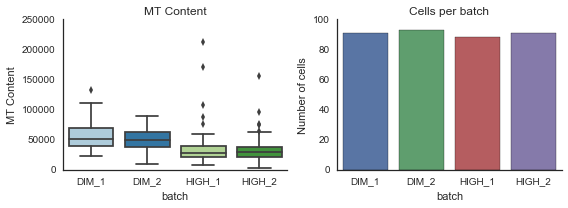

In [146]:
def explore_quality_control(x, y, logy):
    x = x.lower()
    if x == 'batch':
        fig, axes = plt.subplots(figsize=(8, 3), ncols=2)
        ax = axes[0]
        if logy:
            ax.set_yscale('log')
        sns.boxplot(y=y, x=x, data=macaulay2016, ax=ax, palette='Paired')
        ax.set(title=y)
        
        ax = axes[1]
        sns.countplot(x, data=macaulay2016)
        ax.set(ylabel="Number of cells", title='Cells per batch')
    else:
        fig, ax = plt.subplots(figsize=(30, 3))
        macaulay2016[y].plot(kind='bar', logy=logy, ax=ax)
        ax.set(ylim=(0, macaulay2016[y].max()*1.05), title=y)
        
    sns.despine()
    fig.tight_layout()

ipywidgets.interact(explore_quality_control,
                    x=ipywidgets.Dropdown(value='Cells', options=['Cells', 'Batch'], description='x-axis'),
                    y=ipywidgets.Dropdown(value='MT Content', options=['MT Content', 'ERCC Content', 
                                                                       '% Assigned tags (proxy for mapped reads)',
                                                                       'detected_genes', 'total_molecules'],
                                          description='y-axis'),
                    logy=ipywidgets.Checkbox(value=False, description='Set the y-axis as log10-scale?'));

## Dealing with zeros and "drop-outs"
Papers have looked into the capture efficiency of single-cell data and have estimated that the Fluidigm C1 capture 5-10% of the total mRNA content of the cell [citation needed], and the genes whose expression is measured in some cells but not others are called "drop outs."
 
![](https://upload.wikimedia.org/wikipedia/en/a/a3/Kanyewest_collegedropout.jpg)
Kanye West's "The College Dropout" (2004)

School Spirit (Skit 2)
> You keep it going man<br>
> You keep those books rolling<br>
> You pick up all those books that you're gonna read and not remember<br>
> And you roll, man<br>
> You get that associate's degree, okay?<br>
> Then you get your bachelor's<br>
> Then you get your masters<br>
> Then you get your masters' masters<br>
> Then you get your doctorate<br>
> You go man!<br>
> And then when everyone says quit<br>
> You show them those degrees, man<br>
> When everyone says "Hey, you're not working, you're not making any money"<br>
> You say "You look at my degrees, and you look at my life<br>
> Yeah, I'm 52! So what?<br>
> Hate all you want, but I'm smart, I'm so smart<br>
> And I'm in school<br>
> All these guys out here making money all these ways<br>
> And I'm spending mine to be smart!<br>
> You know why?<br>
> Cause when I die buddy<br>
> You know what's gonna keep me warm?<br>
> That's right, those degrees."<br>

### Coefficient of Variation

The way that [Brennecke et al 2013](http://www.ncbi.nlm.nih.gov/pubmed/24056876) deal with this is by looking at the dispersion of genes with a metric called "coefficient of variation squared" or "$CV^2$" with $\mu$ indicating the mean gene expression across cells, and $\sigma$ indicating the standard deviation of gene expression across cells, $CV^2$ is defined by,

$CV^2 = \left(\frac{\sigma}{\mu}\right)^2$

They then plot the $CV^2$ (y-axis) as a function of the mean gene expression (x-axis):

![](figures/brennecke2013_figure3.png)

The brown dots are all genes, the blue indicate the spike-ins, and the pink indicates the genes reliably variant more than the ERCCs. They then argue that these are the genes whose biological variance exceeds the technical variance. This is really only appropriate when you have exact counts for ERCCs and genes using UMIs because otherwise you're not fully confident of the number of counts.

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


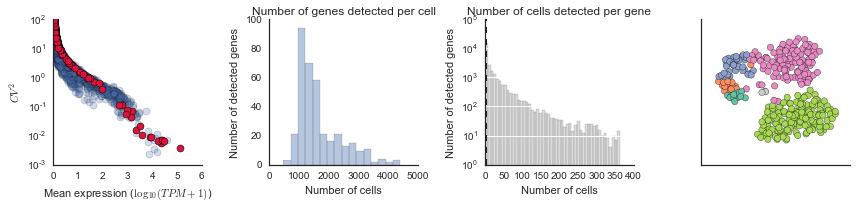

In [147]:
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE


ica_columns = ['difference_component', 'within_small_component', 'outlier_component', 'within_large_component']


import numpy as np

macaulay2016_expression = pd.read_csv('../4._Case_Study/macaulay2016/gene_expression_s.csv', index_col=0)
# Sort the rows and columns
macaulay2016_expression = macaulay2016_expression.sort_index(0).sort_index(1)

# Use only cells that pass QC
macaulay2016_expression = macaulay2016_expression[macaulay2016.index[macaulay2016['Pass QC']]]

ercc_names = [x for x in macaulay2016_expression.index if 'ERCC' in x]

ercc_original = macaulay2016_expression.loc[ercc_names]

macaulay2016_expression_genes = macaulay2016_expression.loc[macaulay2016_expression.index.difference(ercc_names)]

# Rescale just the genes to TPM since now we removed the ERCCs by rescaling each sample (column)
macaulay2016_expression_genes = (macaulay2016_expression_genes / macaulay2016_expression_genes.sum()) * 1e6


def explore_thresholds(min_log_tpm, min_n_cells, log_base, logy=True):
    if log_base == 'e':
        expression = np.log(macaulay2016_expression_genes + 1)
        ercc = np.log(ercc_original + 1)
    elif log_base == '2':
        expression = np.log2(macaulay2016_expression_genes + 1)
        ercc = np.log2(ercc_original + 1)
    elif log_base == '10':
        expression = np.log10(macaulay2016_expression_genes + 1)
        ercc = np.log10(ercc_original + 1)
    else:
        raise ValueError("Not a valid log base")
        
    genes_detected_per_cell = (expression > min_log_tpm).sum(axis=0)
    cells_detected_per_gene = (expression > min_log_tpm).sum(axis=1)
    
    mask = (expression > min_log_tpm).sum(axis=1) >= min_n_cells
    expression = expression.ix[mask]
    
    # Use only cells that have an assigned cluster color
    cell_color = macaulay2016.loc[expression.columns, 'cluster_color'].dropna()
    cell_color = cell_color.map(eval)
    expression = expression[cell_color.index]

    # Calculate coefficient of variation for expression
    mean = expression.mean(axis=1)
    std = expression.std(axis=1)
    
    # Coefficient  of variation squared
    cv2 = np.square(std/mean)
    
    # CV for ERCCs
    mean_ercc = ercc.mean(axis=1)
    std_ercc = ercc.std(axis=1)
    cv2_ercc = np.square(std_ercc/mean_ercc)
    
    fig, axes = plt.subplots(figsize=(12, 3), ncols=4)
    ax = axes[0]
    ax.semilogy(mean, cv2, 'o', alpha=0.25, markeredgewidth=0.5)
    ax.semilogy(mean_ercc, cv2_ercc, 'o', color='Crimson', markeredgewidth=0.5) 
    ax.set(xlabel='Mean expression ($\log_{{{}}}(TPM+1)$)'.format(log_base), ylabel='$CV^2$', ylim=(1e-3, 1e2))
    sns.despine()

    ax = axes[1]
    sns.distplot(genes_detected_per_cell, ax=ax, kde=False)
    ax.set(title='Number of genes detected per cell', ylabel='Number of detected genes', xlabel='Number of cells')
    ax.locator_params(nbins=5)  # reduce the number of ticks to max 6 (5 bins between 6 ticks)
    sns.despine()

    ax = axes[2]
    sns.distplot(cells_detected_per_gene, kde=False, ax=ax, hist_kws=dict(zorder=-1), color='darkgreY')
    if logy:
        ax.set_yscale('log')
    ax.grid(axis='y', color='white', zorder=1)
    ymin, ymax = ax.get_ylim()
    ax.vlines(min_n_cells, ymin, ymax, linestyle='--')
    ax.set(xlim=(0, 400), xlabel='Number of cells', ylabel='Number of detected genes', 
           title='Number of cells detected per gene')

    
    ica = FastICA(n_components=4, random_state=3984)
    decomposed = pd.DataFrame(ica.fit_transform(expression.T.copy()), index=expression.columns,  columns=ica_columns)

    embedder = TSNE(n_components=2, perplexity=75, random_state=254)
    embedded = pd.DataFrame(embedder.fit_transform(decomposed))
    
    ax = axes[3]
    ax.scatter(embedded[0], embedded[1], c=cell_color, s=40)
    # Empty the tick labels
    ax.set(xticks=[], yticks=[])
    sns.despine()
    fig.tight_layout()

ipywidgets.interact(explore_thresholds, 
                    min_log_tpm=ipywidgets.IntSlider(min=0, max=10, value=1, 
                                                     description='Expression Threshold: Minimum log(TPM+1)'), 
                    min_n_cells=ipywidgets.IntSlider(min=0, max=50, value=3,
                                                    description='Minimum number of cells'), 
                    log_base=ipywidgets.Dropdown(options=['e', '2', '10'], value='10', description="log_{X} ?"),
                    logy=ipywidgets.Checkbox(True, description='Log-scale the y-axis of the histogram in the second plot?'));

The default values are what they used in the paper.

Here's an explanation of the panels:

* Mean vs CV for expressed genes
* The distribution of for each cell, how many genes were detected
* The distribution of for each gene, how many cells detected that gene
* A dimensionality reduction plot of the data. We'll talk about these exact algorithms tomorrow, for now, pay attention to how it looks relative to Figure 1c from the Macaulay paper.

## The conclusion here is... thresholds matter!